# Basic Tracking with DIPY
## Deterministic and Probabilistic Tractography Using Basic Stopping Criteria

**Author**: Monika Doerig

**Date**: 5 Dec 2025

### Citation and Resources:

#### Tools included in this workflow
__DIPY:__
- Garyfallidis, E., Brett, M., Amirbekian, B., Rokem, A., van der Walt, S., Descoteaux, M., Nimmo-Smith, I., & Dipy Contributors (2014). Dipy, a library for the analysis of diffusion MRI data. Frontiers in neuroinformatics, 8, 8. [https://doi.org/10.3389/fninf.2014.00008](https://doi.org/10.3389/fninf.2014.00008)

__FURY - Free Unified Rendering in Python:__
- Eleftherios Garyfallidis, Serge Koudoro, Javier Guaje, Marc-Alexandre Côté, Soham Biswas, David Reagan, Nasim Anousheh, Filipi Silva, Geoffrey Fox, and Fury Contributors. "FURY: advanced scientific visualization." Journal of Open Source Software 6, no. 64 (2021): 3384. [https://doi.org/10.21105/joss.03384](https://doi.org/10.21105/joss.03384)
- [FURY Home](https://fury.gl/latest/index.html)



#### Educational resources
- [Fiber Tracking Tutorials DIPY (v1.9.0)](https://docs.dipy.org/1.9.0/examples_built/fiber_tracking/index.html)

  ## Table of Content
  [Introduction](#Introduction)  
  [Data Preparation](#Data-Preparation)  
  [Step 1: Diffusion model](#Step-1:-Diffusion-model)  
  [Step 2: Stopping criterion](#Step-2:-Stopping-criterion)   
  [Step 3: Seeding](#Step-3:-Seeding)  
  [Step 4: Local Tracking: Probabilistic and Deterministic Approaches](#Step-4:-Local-Tracking:-Probabilistic-and-Deterministic-Approaches)

## Introduction 

Local fiber tracking is a method for reconstructing white matter pathways from diffusion MRI data. It models the trajectories of fiber bundles by following local orientation information derived from the diffusion signal. The key idea is that if the dominant diffusion direction within each voxel is known, one can integrate along these directions to reconstruct streamlines representing possible neural tracts.

To perform local fiber tracking, four components are required:

**1.** A model to estimate local diffusion directions (e.g., DTI, CSA or CSD).

**2.** A stopping criterion that defines when a streamline should terminate (e.g., based on fractional anisotropy or tissue boundaries).

**3.** A set of seed points from which tracking begins.

**4.** Local tracking - the actual tractography execution.

In this notebook, we will combine these components to perform tractography using the DIPY library, demonstrating each step of the local tracking workflow.

### Goal

Build practical understanding of local tractography workflows in DIPY, from diffusion modeling to streamline generation.

#### Learning Objectives

By the end of this notebook, you will be able to:

- Load and minimally preprocess diffusion MRI data in DIPY.

- Fit DTI, CSA and CSD models and visualize derived metrics (FA, FOD).

- Define stopping criteria and seed regions for tractography.

- Run both deterministic and probabilistic tractography.

- Compare outputs visually and quantitatively.


## Install and import python libraries

In [1]:
%%capture 
! pip install numpy==1.26.4 vtk==9.4.0 fury==0.11.0 dipy==1.9.0 nibabel==5.3.2 scipy==1.14.1

In [2]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from dipy.segment.mask import median_otsu
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import TensorModel, fractional_anisotropy, color_fa
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel, auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere, get_fnames, read_stanford_hardi, get_sphere
from dipy.tracking.utils import seeds_from_mask
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion, BinaryStoppingCriterion
from dipy.direction import DeterministicMaximumDirectionGetter, ProbabilisticDirectionGetter, peaks_from_model
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines, length
from dipy.viz import actor, colormap, has_fury, window
from dipy.core.histeq import histeq
from dipy.io.image import load_nifti, load_nifti_data, save_nifti
from dipy.sims.voxel import single_tensor_odf
from scipy.ndimage import binary_dilation
from IPython.display import  Image

## Data Preparation

### Load Stanford HARDI dataset from Stanford provided by DIPY

In [3]:
# Load example diffusion data
img, gtab = read_stanford_hardi()
data = img.get_fdata()

#affine = img.affine
affine = np.eye(4)

print("Data shape:", data.shape)
print("b-values (unique):", np.unique(gtab.bvals)[:10], '…')

Data shape: (81, 106, 76, 160)
b-values (unique): [   0. 2000.] …


This dataset provides a label map in which all white matter tissues are labeled either 1 or 2. Let’s create a white matter mask to restrict tracking to the white matter.

In [4]:
label_fname = get_fnames(name="stanford_labels")
t1_fname = get_fnames(name="stanford_t1")
labels = load_nifti_data(label_fname)
t1_data = load_nifti_data(t1_fname)

# Create white matter mask - also dilate this mask by 1 voxel to ensure streamlines reach the grey matter
white_matter = binary_dilation((labels == 1) | (labels == 2))

### Minimal preprocessing
To keep things simple, we’ll compute a brain mask using **median_otsu**. 

This function is inspired from Mrtrix’s bet which has default values median_radius=3, numpass=2. However, from tests on multiple 1.5T and 3T data from GE, Philips, Siemens, the most robust choice is median_radius=4, numpass=4 (default)

In [5]:
# Compute a quick brain mask
b0_masked, brain_mask = median_otsu(
    data,
    vol_idx=np.where(gtab.bvals < 50)[0],

)
b0_masked.shape

(81, 106, 76, 160)

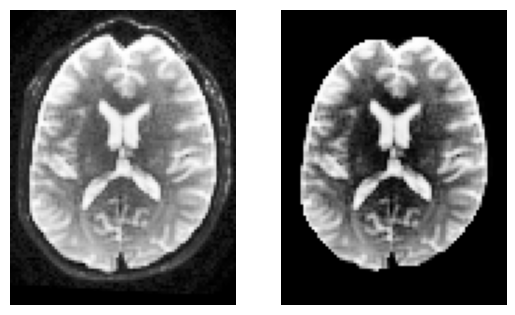

In [6]:
sli = data.shape[2] // 2

plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(histeq(data[:, :, sli,0].astype("float")).T, cmap="gray", origin="lower")

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(histeq(b0_masked[:, :, sli,0].astype("float")).T, cmap="gray", origin="lower")

## Step 1: Diffusion model

To reconstruct white matter pathways, we first need to estimate the **local fiber directions** within each voxel.
In diffusion MRI, water molecules diffuse more easily along axons than across them — this directional dependence can be modeled to infer underlying fiber orientations.

Several models can be used to represent this directional information. We will look into the following three models (for a complete overview of reconstruction models available in DIPY, see
[here](https://docs.dipy.org/1.9.0/examples_built/index.html#reconstruction):

A) **DTI (Diffusion Tensor Imaging)**  
- Estimates a single principal diffusion direction per voxel.
- Computes scalar measures such as Fractional Anisotropy (FA) and Mean Diffusivity (MD).
- Simple and fast, but cannot resolve crossing fibers, which are present in a substantial portion of white matter voxels

> While FA is a scalar measure of anisotropy, you can also visualize a tensor ODF derived from the fitted tensor. This ODF is Gaussian-shaped and symmetric, representing the diffusion profile of a single tensor. It provides intuition about fiber orientation but is limited in regions with crossing or branching fibers.

B) **CSA (Constant Solid Angle) ODFs**:  
- Estimates an Orientation Distribution Function (ODF) per voxel from the diffusion-weighted signal.
- Peaks of the ODF indicate likely fiber orientations.
- Can represent multiple orientations, but peaks may be less sharp than CSD, potentially leading to lower tracking precision

> The CSA model helps illustrate the transition from single-tensor representations to full ODFs, showing how we move toward richer, multi-directional voxel-wise information for tractography.

C) **CSD (Constrained Spherical Deconvolution)**:  
- Estimates the Fiber Orientation Distribution (FOD) by deconvolving the diffusion signal with a single-fiber response function. The FOD is represented using spherical harmonics (SH).
- Resolves multiple distinct fiber populations per voxel (crossings, branchings). 
- Produces sharper, more accurate orientation peaks, improving both deterministic and probabilistic tractography  

> In short: while DTI and CSA provide useful but simplified diffusion representations, CSD offers a more precise reconstruction of fiber orientations, especially in regions with complex microstructure.

### A) Reconstruction of the diffusion signal with DTI (single tensor) model

Let's start with DTI, the simplest diffusion model, before exploring more complex representations with CSA and CSD.

We will visualize DTI results in several ways:

- FA map — highlights anisotropic regions like white matter.

- Tensor ellipsoids — show the shape and orientation of diffusion tensors in small regions (e.g., corpus callosum).

- Tensor ODFs — visualize the diffusion orientation profile derived from the single tensor in each voxel.

In [7]:
# Voxel reconstruction with DTI - instantiate TensorModel and fit it to the data
tenmodel = TensorModel(gtab)
tenfit = tenmodel.fit(b0_masked)

FA = fractional_anisotropy(tenfit.evals)

The fitting will not be accurate in the background of the image as there is no signal and possibly we will find FA values with nans (not a number). We can easily remove these in the following way.

In [8]:
FA[np.isnan(FA)] = 0

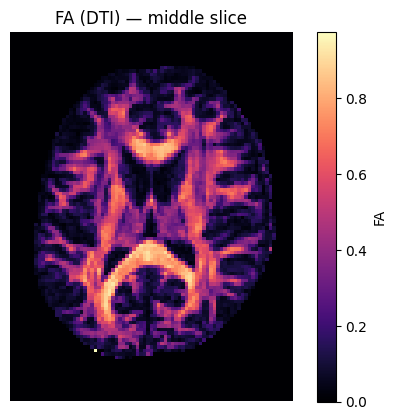

In [9]:
# Show FA slice
plt.figure()
plt.imshow(FA[:, :, sli].T, origin='lower',cmap='magma')
plt.title('FA (DTI) — middle slice')
plt.colorbar(label='FA')
plt.axis('off'); plt.show()

We can also compute the colored FA or RGB-map. First, FA needs tob e scaled between 0 and 1, then the RGB map can be computed and visualized.

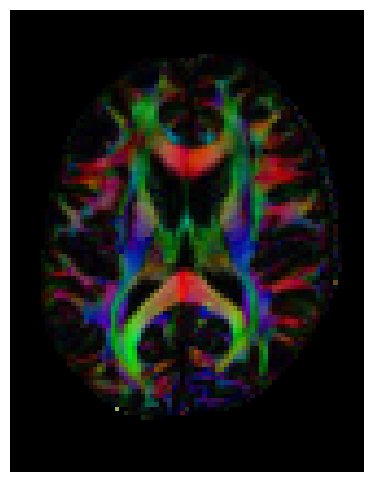

In [10]:
FA = np.clip(FA, 0, 1)
RGB = color_fa(FA, tenfit.evecs)

plt.figure(figsize=(6, 6))
plt.imshow(np.rot90(RGB[:, :, sli, :], k=1)) # k=1 → 90° counterclockwise
plt.axis('off');

Let's also visualize the tensor ellipsoids of a small rectangular area in an axial slice of the corpus callosum (CC):

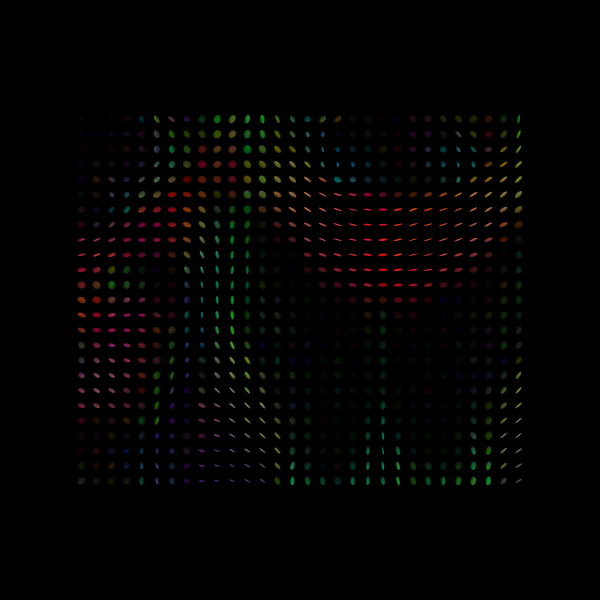

In [11]:
sphere = get_sphere(name="repulsion724")
scene = window.Scene()
evals = tenfit.evals[20:50, 55:80, 38:39]
evecs = tenfit.evecs[20:50, 55:80, 38:39]

cfa = RGB[20:50, 55:80, 38:39]
cfa /= cfa.max()

scene.add(
    actor.tensor_slicer(evals, evecs, scalar_colors=cfa, sphere=sphere, scale=0.3)
)

window.record(
    scene=scene, n_frames=1, out_path="tensor_ellipsoids.png", size=(600, 600)
)

Image("tensor_ellipsoids.png")

Finally, we will visualize the tensor Orientation Distribution Functions for the same area as we did with the ellipsoids.

In [12]:
scene.clear()

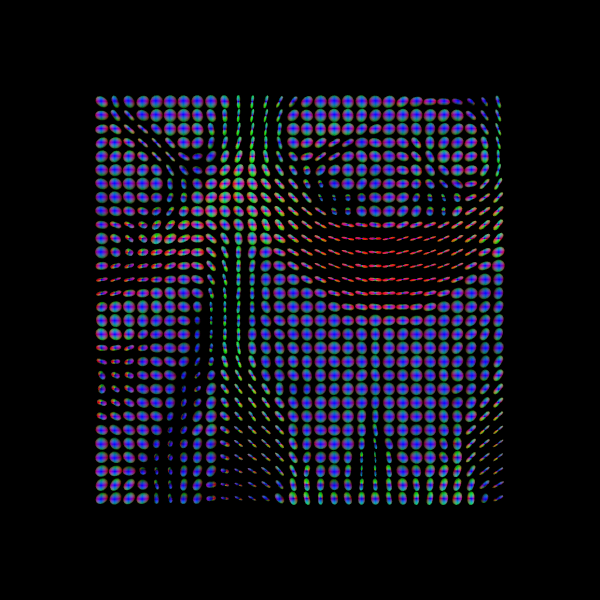

In [13]:
tensor_odfs = tenmodel.fit(data[20:50, 55:85, 37:38]).odf(sphere)

odf_actor = actor.odf_slicer(tensor_odfs, sphere=sphere, scale=0.5, colormap=None)
scene.add(odf_actor)

window.record(scene=scene, n_frames=1, out_path="tensor_odfs.png", size=(600, 600))
Image("tensor_odfs.png")

### B) CSA (Constant Solid Angle) ODF

Here, we’ll use `peaks_from_model` to apply the `CsaOdfModel` to each white matter voxel and estimate fiber orientations that we can use for tracking. This function requires a reconstruction model, the diffusion data, and a sphere as input. The sphere is an object that represents the spherical discrete grid where the ODF values will be evaluated.  
The `csa_peaks` object contains several useful attributes:  `gfa` (generalized fractional anisotropy), `peak_dirs` (peak directions), `peak_values` (maxima values of the ODF), `peak_indices` (position on the discrete sphere), `shm_coeff` (spherical harmonic coefficients) and `odf` (the full orientation distribution function). 


- [DIPY's example Reconstruction with Constant Solid Angle](https://docs.dipy.org/stable/examples_built/reconstruction/reconst_csa.html#)

In [14]:
# Instantiate CSA model with spherical harmonic order (l) of 6
csa_model = CsaOdfModel(gtab, sh_order_max=6)

# Calculate properties of the ODFs and return for example the peaks and their indices
csa_peaks = peaks_from_model(
    csa_model,
    data,
    default_sphere,
    relative_peak_threshold=0.8,
    min_separation_angle=45,
    mask=white_matter,
)

For quality assurance, we can visualize an axial slice from the direction field estimated by the CSA model. Each glyph represents a local fiber orientation derived from the ODF peaks. The underlying ODFs are not shown here.

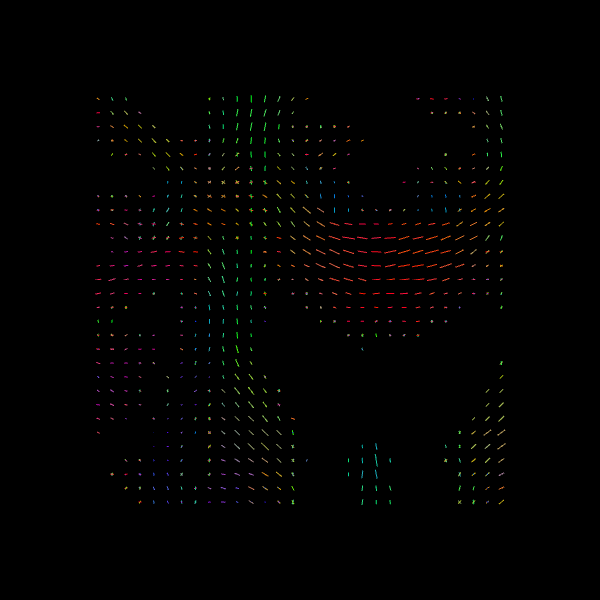

In [15]:
scene = window.Scene()
scene.add(
    actor.peak_slicer(
        csa_peaks.peak_dirs[20:50, 55:85, 37:38], peaks_values=csa_peaks.peak_values[20:50, 55:85, 37:38], colors=None
    )
)

window.record(scene=scene, out_path="csa_direction_field.png", size=(600, 600))

Image("csa_direction_field.png")

### C) CSD (Constrained Spherical Deconvolution)

Constrained Spherical Deconvolution (CSD) reconstructs the fiber Orientation Distribution Function (fODF) by estimating how the diffusion signal would look for a single, coherently oriented fiber (the response function) and then deconvolving this response from the measured signal. This allows recovery of multiple fiber orientations within a voxel, making it particularly effective in regions with crossing fibers.


- https://docs.dipy.org/stable/examples_built/reconstruction/reconst_csd.html#

First, let's verify the b-values of the dataset by looking at the attribute `gtab.bvals`. 

In [16]:
gtab.bvals

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000., 2000.,
       2000., 2000.,

With this dataset with multiple gradient directions, we can proceed with the two steps of CSD.
1. Estimation of the fiber response function
2. 
Use the response function to reconstruct the fODF

#### Step 1. Estimation of the fiber response function from a local brain region

To estimate the **single-fiber response function**, we can use a brain region where fibers are known to be coherent and aligned, such as the **corpus callosum**. The `auto_response_ssst` function automates this process: it selects a it selects a small cuboid ROI (typically centered in the brain), computes FA values, and extracts the response function from voxels with **FA > 0.7** — likely corresponding to single-fiber regions.

Internally, this function first creates a mask of suitable voxels (`mask_for_response_ssst`) and then computes the response function within that mask (`response_from_mask_ssst`). These two steps can also be performed manually; the resulting responses should be identical. 

In [17]:
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)

The response tuple contains two elements: an array with the eigenvalues of the response function and the average S0 for this response:

In [18]:
print(response)

(array([0.00139919, 0.0003007 , 0.0003007 ]), 416.7372408293461)


The response tensor should be prolate and anisotropic, with the axial diffusivity about five times greater than the radial diffusivity (i.e., the two smaller eigenvalues are equal and roughly one-fifth of the largest).

In [19]:
print(ratio)

0.21491283972218628


We can double-check that we have a good response function by visualizing the response function’s ODF. Here is how you would do that:

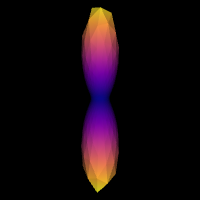

In [20]:
scene = window.Scene()
evals = response[0]
evecs = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T


response_odf = single_tensor_odf(default_sphere.vertices, evals=evals, evecs=evecs)
# transform our data from 1D to 4D
response_odf = response_odf[None, None, None, :]
response_actor = actor.odf_slicer(
    response_odf, sphere=default_sphere, colormap="plasma"
)
scene.add(response_actor)

window.record(scene=scene, out_path="csd_response.png", size=(200, 200))
Image("csd_response.png")

#### Step 2. fODF reconstruction
After estimation the response function, we can start the deconvolution process:

In [21]:
# Instantiate the CSD model 
csd_model = ConstrainedSphericalDeconvModel(gtab, response)

In [22]:
# Fit the model and show the CSD-based ODFs also known as FODFs (fiber ODFs).
csd_fit = csd_model.fit(data[20:50, 55:85, 38:39])
csd_odf = csd_fit.odf(default_sphere)

100%|██████████| 900/900 [00:00<00:00, 3629.00it/s]


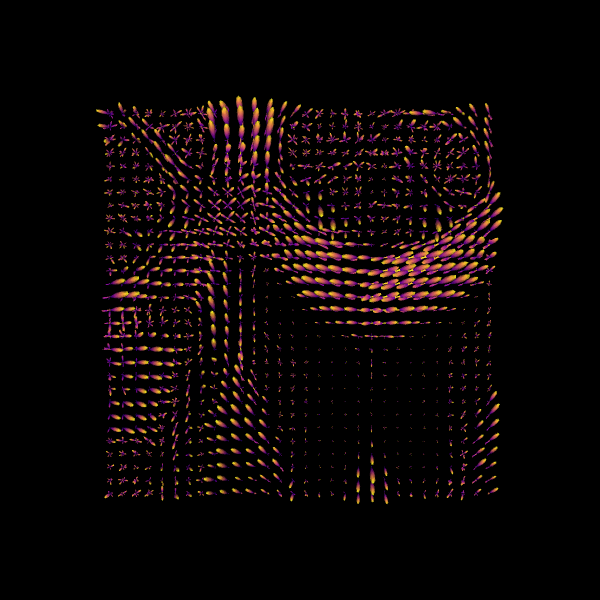

In [23]:
scene.clear()

fodf_spheres = actor.odf_slicer(
    csd_odf, sphere=default_sphere, scale=0.9, norm=False, colormap="plasma"
)

scene.add(fodf_spheres)

window.record(scene=scene, out_path="csd_odfs.png", size=(600, 600))
Image("csd_odfs.png")

We can also find the peak directions (maxima) of the ODFs with `peaks_from_model`.

In [24]:
# Find peak directions (maxima) of the ODFs
peaks_csd = peaks_from_model(model=csd_model,
                         data=data,
                         sphere=default_sphere,           
                         relative_peak_threshold=0.5, 
                         min_separation_angle=25, 
                         mask=white_matter, 
                         return_sh=True,
                         parallel=False)


print("CSD peaks computed. SH shape:", peaks_csd.shm_coeff.shape)

CSD peaks computed. SH shape: (81, 106, 76, 45)


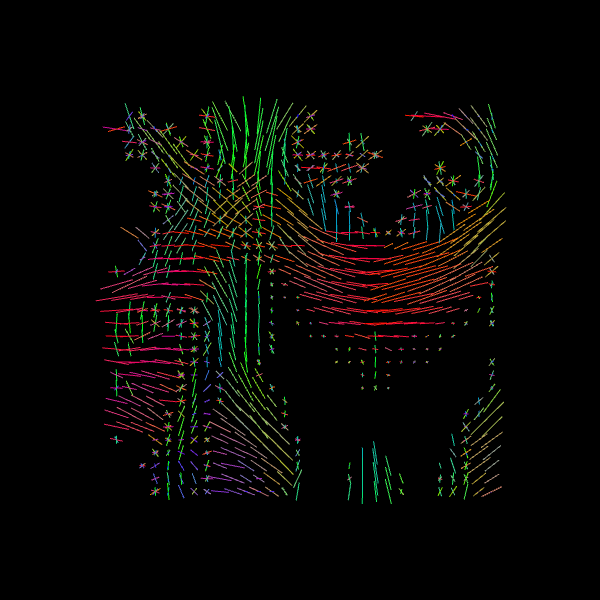

In [25]:
scene = window.Scene()
scene.add(
    actor.peak_slicer(
        peaks_csd.peak_dirs[20:50, 55:85, 38:39], peaks_values=peaks_csd.peak_values[20:50, 55:85, 38:39],
        colors=None,
    )
)

window.record(scene=scene, out_path="csd_direction_field.png", size=(600, 600))

Image("csd_direction_field.png")

We now visualize both the ODFs and peaks in the same space.

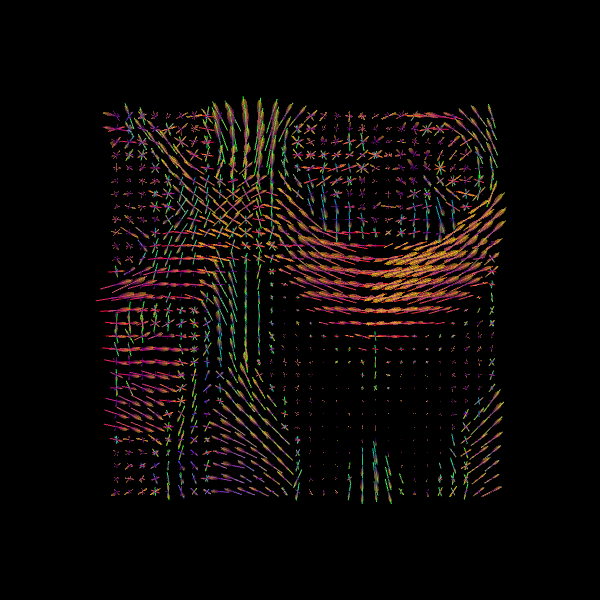

In [26]:
fodf_spheres.GetProperty().SetOpacity(0.4)

scene.add(fodf_spheres)

window.record(scene=scene, out_path="csd_both.png", size=(600, 600))
Image("csd_both.png")

> **Why DTI, CSA and CSD?** DTI provides intuitive scalar maps (FA/MD) but only estimates a single fiber direction per voxel. CSA and CSD can both resolve multiple fiber orientations, with CSD producing sharper FODs that improve tractography accuracy in complex white matter regions


## Step 2: Stopping criterion

Before running tractography, we must define when to stop tracking.
The stopping criterion determines whether tracking continues or terminates at each step along a streamline. Tracking typically stops when:

- The streamline reaches a region with unreliable diffusion information (e.g., low anisotropy)
- It exits the white matter into gray matter or CSF
- It reaches the image boundaries

In this notebook, we'll explore two basic stopping criteria:
1) Threshold Stopping Criterion — stops when a scalar metric (FA or GFA) falls below a threshold
2) Binary Stopping Criterion — stops when the streamline exits a predefined white matter mask

Both approaches produce streamlines classified as either:

- Valid: ending at appropriate stopping points (e.g., at mask boundaries or image edges)
- Invalid: terminating prematurely in regions where tracking should continue


> Note: More advanced stopping criteria, such as Anatomically-Constrained Tractography (ACT), will be covered in a separate notebook on advanced tracking methods.

1️⃣ **Threshold Stopping Criterion**

The threshold stopping criterion stops tracking when an interpolated scalar value falls below a specified threshold. We'll demonstrate this using the FA map from DTI with a threshold of 0.15.
At each tracking step, the FA value is estimated using trilinear interpolation at the streamline's current position. If FA < 0.15, tracking stops.

**Streamline stopping states:**

- `ENDPOINT`: tracking stopped because the FA value fell below the threshold
- `OUTSIDEIMAGE`: tracking stopped because the position was outside the image domain
- `TRACKPOINT`: tracking stopped because no valid direction was available, even though FA ≥ threshold at that location

In [27]:
fa_thr = 0.15
stopping_criterion = ThresholdStoppingCriterion(FA, fa_thr)

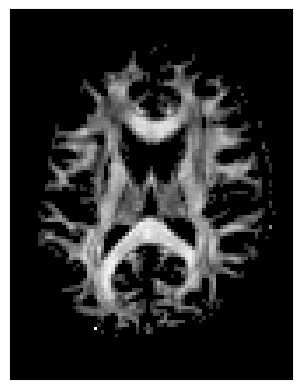

In [28]:
fig = plt.figure()
mask_fa = FA.copy()
mask_fa[mask_fa < 0.15] = 0
plt.xticks([])
plt.yticks([])
plt.imshow(mask_fa[:, :, data.shape[2] // 2].T, cmap='gray', origin='lower',
           interpolation='nearest')

> This criterion is data-driven and flexible, but streamlines may occasionally extend slightly beyond the anatomical white matter boundaries.

2️⃣ **Binary Stopping Criterion**

Instead of stopping based on a continuous scalar map (like FA), the binary criterion relies solely on a **white matter mask**. Tracking is allowed only inside the mask—as soon as the current position lies outside it, the streamline terminates.

This criterion uses nearest-neighbor interpolation to determine whether the current tracking location is inside (mask = 1) or outside (mask = 0) the white matter.

__Streamline stopping states:__

- `ENDPOINT`: tracking stopped because the mask value was 0 (outside white matter)

- `OUTSIDEIMAGE`: tracking stopped because the position was outside the image domain

- `TRACKPOINT`: tracking stopped due to no available direction at that location, even though it was inside the mask

In [29]:
stopping_criterion_binary = BinaryStoppingCriterion(white_matter)

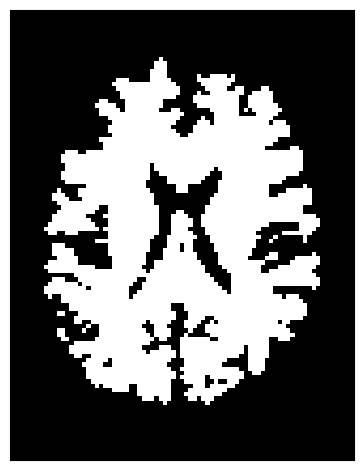

In [30]:
fig = plt.figure()
plt.xticks([])
plt.yticks([])
fig.tight_layout()
plt.imshow(white_matter[:, :, data.shape[2] // 2].T, cmap='gray',
           origin='lower', interpolation='nearest')


> This approach is simpler and ensures that streamlines remain strictly within the white matter mask.

## Step 3: Seeding

Next, we define where tracking starts — the seed points.
Each seed acts as a starting location for streamline propagation based on local fiber orientations.

You can choose seeds:

- In a **specific region of interest (ROI)**, such as the corpus callosum.

- Or throughout the **entire white matter** to reconstruct whole-brain tractography.

For example, to seed in the corpus callosum:

In [31]:
# Seeding in the corpus callosum (label value 2)
seed_mask = labels == 2
seeds_mask = seeds_from_mask(seed_mask, affine, density=1) #places one seed per voxel
print("Number of seeds:", len(seeds_mask))

Number of seeds: 505


If you want to do whole-brain tractography instead:

In [32]:
# Whole-brain seeding
seeds_wm = seeds_from_mask(white_matter, affine, density=1)
print("Number of seeds:", len(seeds_wm))

Number of seeds: 96983


## Step 4: Local Tracking: Probabilistic and Deterministic Approaches


With the diffusion model (Step 1), stopping criteria (Step 2), and seeds (Step 3) defined, we are ready to perform tractography. 

DIPY supports two main approaches for local tracking:

- **Deterministic:** follows the principal fiber orientation at each step.
- **Probabilistic:** samples directions from the fiber orientation distribution, accounting for uncertainty.

Both approaches use the same seeds and stopping criteria but differ in how the next tracking direction is chosen.

### Probabilistic tractography

Probabilistic fiber tracking is one approach for reconstructing white matter connections using diffusion MRI. Unlike deterministic tractography, which follows the peak fiber orientation at each step, probabilistic tractography samples the direction of each step from a distribution of possible orien.taIn this approach, the Fiber Orientation Distribution (FOD) estimated by the CSD model encodes the relative strength of different fiber orientations within each voxel. The FOD can be discretized on a well-distributed sphere to obtain directional weights (akin to a probability mass function, PMF) for sampling tracking directions. Since a PMF cannot have negative values, any negative FOD amplitudes are clipped to zero.

This probabilistic sampling allows streamlines to explore multiple plausible pathways, capturing uncertainty in local fiber orientation. This is particularly valuable in complex white matter regions with crossing or branching fibers, where a single deterministic direction may oversimplify the underlying anatomy. As with deterministic tracking, probabilistic streamlines begin from seed points and are guided by stopping criteria such as white matter masks or FA thresholds.

In [34]:
# Probabilistic direction getting for fiber tracking
# Uses on-the-fly SH-to-PMF conversion for memory efficiency
prob_dg = ProbabilisticDirectionGetter.from_shcoeff(peaks_csd.shm_coeff,
                                                    max_angle=30.,
                                                    sphere=peaks_csd.sphere, 
                                                    sh_to_pmf=True)

Local Tracking is used for probabilistic tractography which takes the direction getter along with the stopping criterion and seeds as input.

In [35]:
streamlines_prob = LocalTracking(direction_getter=prob_dg,
                                 stopping_criterion=stopping_criterion_binary,
                                 seeds=seeds_mask,
                                 affine=affine,
                                 step_size=0.5)
# Compute streamlines
streamlines_prob = Streamlines(streamlines_prob)
print(f"Probabilistic streamlines: {len(streamlines_prob)}")

Probabilistic streamlines: 587


Since we seeded streamlines exclusively from the corpus callosum, all resulting fibers represent interhemispheric connections originating from this region.
Let's visualize them using probabilistic direction getter from SH (peaks_from_model):

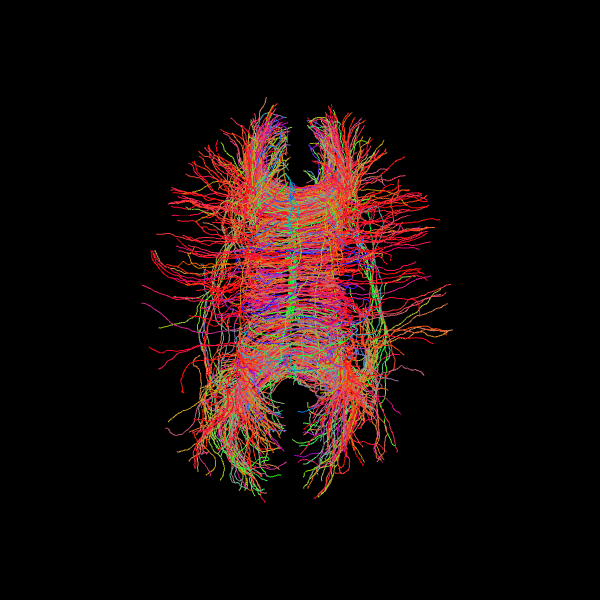

In [36]:
scene = window.Scene()
scene.add(actor.line(streamlines_prob, colors=colormap.line_colors(streamlines_prob)))
window.record(scene=scene, out_path="tractogram_probabilistic.png", size=(600, 600))

Image('tractogram_probabilistic.png')

### Deterministic tractography

We now perform deterministic tractography using the fiber orientation distributions (FODs) estimated with the CSD model. Instead of sampling directions probabilistically, the Deterministic Maximum Direction Getter always follows the direction with the highest value in the distribution at each step, subject to tracking constraints (e.g., maximum turning angle of 30°).

This method uses the full orientation distribution rather than only peak directions, distinguishing it from approaches like EuDX, which rely on peak-following. The resulting streamlines represent the direction of maximum orientation likelihood starting from the defined seed mask.

In [38]:
# Deterministic from CSD peaks
dg_det = DeterministicMaximumDirectionGetter.from_shcoeff(peaks_csd.shm_coeff,
                                                         max_angle=30.,
                                                         sphere=peaks_csd.sphere,
                                                         sh_to_pmf=True)

streamlines_det = LocalTracking(direction_getter=dg_det,
                                stopping_criterion=stopping_criterion_binary,
                                seeds=seeds_mask,
                                affine=affine,
                                step_size=0.5)

streamlines_det = Streamlines(streamlines_det)
print(f"Deterministic streamlines: {len(streamlines_det)}")

Deterministic streamlines: 587


Let's visualize the Corpus Callosum using deterministic maximum direction getter:

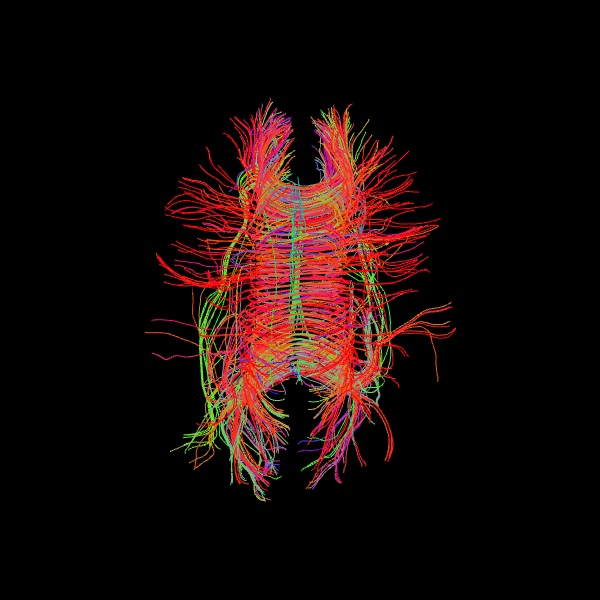

In [39]:
scene = window.Scene()
scene.add(actor.line(streamlines_det, colors=colormap.line_colors(streamlines_det)))
window.record(scene=scene, out_path="tractogram_deterministic.png", size=(600, 600))

Image('tractogram_deterministic.png')

The following alternative visualizations display the corpus callosum streamlines overlaid on T1-weighted anatomical slices (axial at z=35 and sagittal at z=35), with the seed ROI shown as a semi-transparent yellow contour.

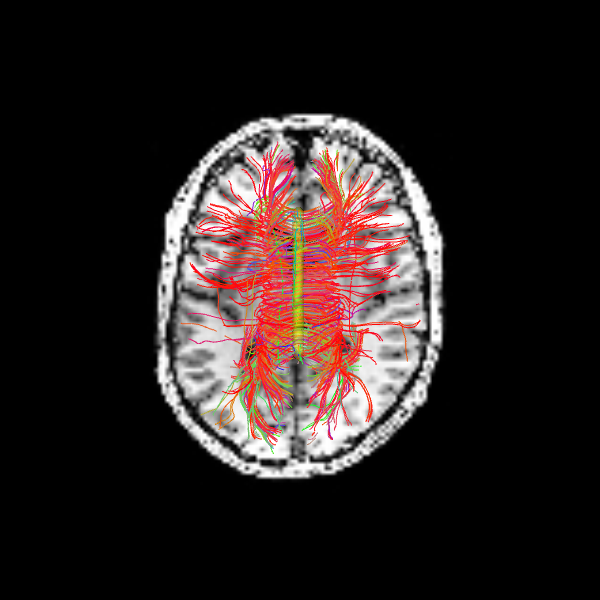

In [42]:
# Make display objects
cc_streamlines_actor = actor.line(
    streamlines_det, colors=colormap.line_colors(streamlines_det)
)
cc_ROI_actor = actor.contour_from_roi(seed_mask, color=(1.0, 1.0, 0.0), opacity=0.5)

vol_actor = actor.slicer(t1_data)

vol_actor.display(x=40) # sagittal slice
vol_actor2 = vol_actor.copy()
vol_actor2.display(z=35) # axial slice

# Add display objects to canvas
scene = window.Scene()
scene.add(vol_actor)
scene.add(vol_actor2)
scene.add(cc_streamlines_actor)
scene.add(cc_ROI_actor)

# Save figure
window.record(
    scene=scene, n_frames=1, out_path="corpuscallosum_axial.png", size=(600, 600)
)
Image("corpuscallosum_axial.png")

The sagittal view illustrates these interhemispheric pathways connecting the two hemispheres.

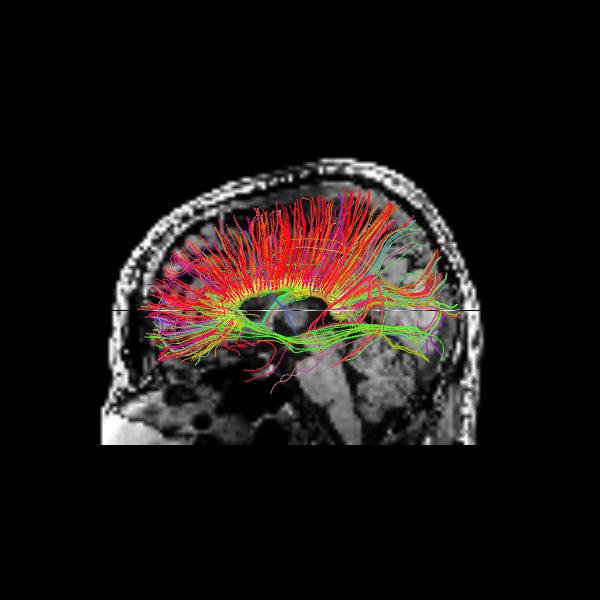

In [43]:
scene.set_camera(position=[-1, 0, 0], focal_point=[0, 0, 0], view_up=[0, 0, 1])
window.record(
    scene=scene, n_frames=1, out_path="corpuscallosum_sagittal.png", size=(600, 600)
)
Image("corpuscallosum_sagittal.png")

### Quantitative Comparison of Tracking Methods
As a final step, we compare the deterministic and probabilistic tractography results quantitatively. Since both methods used identical seeds, stopping criteria, and tracking parameters, we can directly compare their outputs in terms of streamline count and length distributions.
Streamline length is a basic metric that provides insight into the spatial extent of reconstructed pathways. By examining the distribution of lengths across all streamlines, we can assess whether the two tracking approaches produce similar or systematically different patterns for this particular white matter structure.

Streamline Statistics:
Deterministic  — n=  587, mean= 50.3 mm, median= 50.5 mm, std= 23.1 mm
Probabilistic  — n=  587, mean= 49.7 mm, median= 51.0 mm, std= 23.1 mm


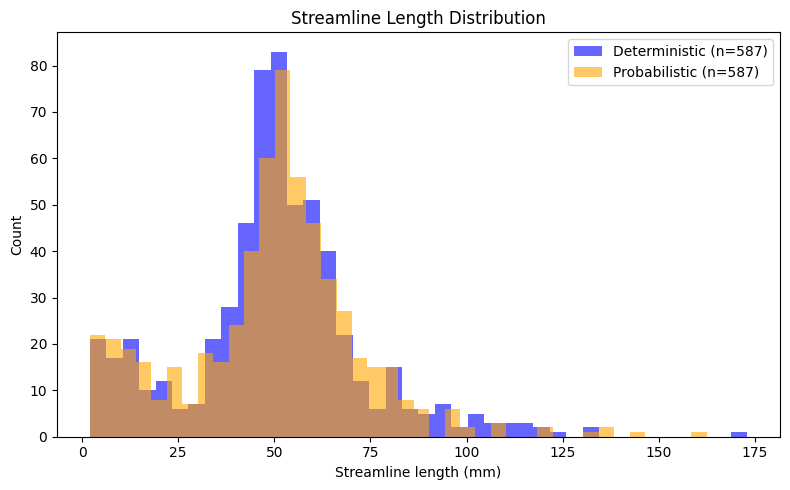

In [44]:
# Compute streamline length distributions (in mm)
len_det = list(length(streamlines_det))
len_prob = list(length(streamlines_prob))

print("Streamline Statistics:")
print(f"Deterministic  — n={len(len_det):>5}, mean={np.mean(len_det):>5.1f} mm, "
      f"median={np.median(len_det):>5.1f} mm, std={np.std(len_det):>5.1f} mm")
print(f"Probabilistic  — n={len(len_prob):>5}, mean={np.mean(len_prob):>5.1f} mm, "
      f"median={np.median(len_prob):>5.1f} mm, std={np.std(len_prob):>5.1f} mm")

plt.figure(figsize=(8, 5))
plt.hist(len_det, bins=40, alpha=0.6, label=f'Deterministic (n={len(len_det)})', color='blue')
plt.hist(len_prob, bins=40, alpha=0.6, label=f'Probabilistic (n={len(len_prob)})', color='orange')
plt.xlabel('Streamline length (mm)')
plt.ylabel('Count')
plt.legend()
plt.title('Streamline Length Distribution')
plt.tight_layout()
plt.show()

### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [45]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-12-05T00:51:41.858665+00:00

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.6.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

numpy     : 1.26.4
nibabel   : 5.3.2
scipy     : 1.14.1
fury      : 0.11.0
dipy      : 1.9.0
matplotlib: 3.10.7
IPython   : 9.6.0

